In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CORE: BINARY UNPACKER (STE) ---
class BinaryUnpacker(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_tensor):
        ctx.save_for_backward(input_tensor)
        return (input_tensor > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_tensor.abs() > 1.0] = 0
        return grad_input

# --- 2. CAMADA CONVOLUCIONAL BINÁRIA ---
class BinaryConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.stride = stride
        self.padding = padding
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x, error_rate=0.0):
        binary_kernels = BinaryUnpacker.apply(self.weights)

        if error_rate > 0:
            noise_mask = (torch.rand_like(binary_kernels) < error_rate).float()
            binary_kernels = torch.abs(binary_kernels - noise_mask)

        return F.conv2d(x, binary_kernels, self.bias, stride=self.stride, padding=self.padding)

# --- 3. ARQUITETURAS ---
class CNN_Standard(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(16 * 28 * 28, 10)

    def forward(self, x, error_rate=0.0):
        weights = self.conv1.weight
        if error_rate > 0:
            weights = weights + torch.randn_like(weights) * error_rate
        x = F.conv2d(x, weights, self.conv1.bias, padding=1)
        x = self.bn1(x)
        x = F.relu(x)
        return self.fc(x.view(x.size(0), -1))

class BGN_ConvNet(nn.Module):
    def __init__(self, expansion=4):
        super().__init__()
        self.hidden = 16 * expansion
        self.conv1 = BinaryConv2d(1, self.hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(self.hidden)
        self.fc = nn.Linear(self.hidden * 28 * 28, 10)

    def forward(self, x, error_rate=0.0):
        x = self.conv1(x, error_rate=error_rate)
        x = self.bn1(x)
        x = F.relu(x)
        return self.fc(x.view(x.size(0), -1))

# --- 4. MOTOR DE TREINO COM PRINTS DETALHADOS ---
def train_model(model, loader, device, name="Modelo", epochs=3):
    print(f"\n>>> Iniciando Treinamento: {name}")
    print("-" * 50)
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    model.train()

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            # Estatísticas em tempo real
            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % 200 == 0:
                acc = 100. * correct / total
                avg_loss = running_loss / (batch_idx + 1)
                print(f"Época: {epoch+1} [{batch_idx * len(data):5d}/{len(loader.dataset)}] | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")

        epoch_acc = 100. * correct / total
        print(f"--- Fim da Época {epoch+1} | Acurácia Final: {epoch_acc:.2f}% ---")

    duration = time.time() - start_time
    print(f"Treinamento concluído em: {duration:.2f}s")

def evaluate_resilience(model, loader, device, error_rates):
    accs = []
    model.eval()
    for er in error_rates:
        correct = 0
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = model(data, error_rate=er)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        accs.append(100. * correct / len(loader.dataset))
    return accs

# --- 5. EXECUÇÃO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000)

# Treino dos modelos com feedback
cnn = CNN_Standard().to(device)
train_model(cnn, train_loader, device, name="CNN Standard (Float32)")

bgn_conv = BGN_ConvNet(expansion=6).to(device)
train_model(bgn_conv, train_loader, device, name="BGN-Conv (Binary Kernels)")


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.4MB/s]



>>> Iniciando Treinamento: CNN Standard (Float32)
--------------------------------------------------
Época: 1 [    0/60000] | Loss: 2.4305 | Acc: 6.25%
Época: 1 [12800/60000] | Loss: 0.4818 | Acc: 87.88%
Época: 1 [25600/60000] | Loss: 0.3526 | Acc: 90.89%
Época: 1 [38400/60000] | Loss: 0.2804 | Acc: 92.60%
Época: 1 [51200/60000] | Loss: 0.2406 | Acc: 93.57%
--- Fim da Época 1 | Acurácia Final: 93.98% ---
Época: 2 [    0/60000] | Loss: 0.1725 | Acc: 98.44%
Época: 2 [12800/60000] | Loss: 0.0711 | Acc: 97.71%
Época: 2 [25600/60000] | Loss: 0.0748 | Acc: 97.59%
Época: 2 [38400/60000] | Loss: 0.0742 | Acc: 97.69%
Época: 2 [51200/60000] | Loss: 0.0739 | Acc: 97.70%
--- Fim da Época 2 | Acurácia Final: 97.71% ---
Época: 3 [    0/60000] | Loss: 0.0359 | Acc: 98.44%
Época: 3 [12800/60000] | Loss: 0.0394 | Acc: 98.78%
Época: 3 [25600/60000] | Loss: 0.0411 | Acc: 98.68%
Época: 3 [38400/60000] | Loss: 0.0433 | Acc: 98.61%
Época: 3 [51200/60000] | Loss: 0.0484 | Acc: 98.46%
--- Fim da Época 3 | Ac


Evaluating Radiation Resilience...


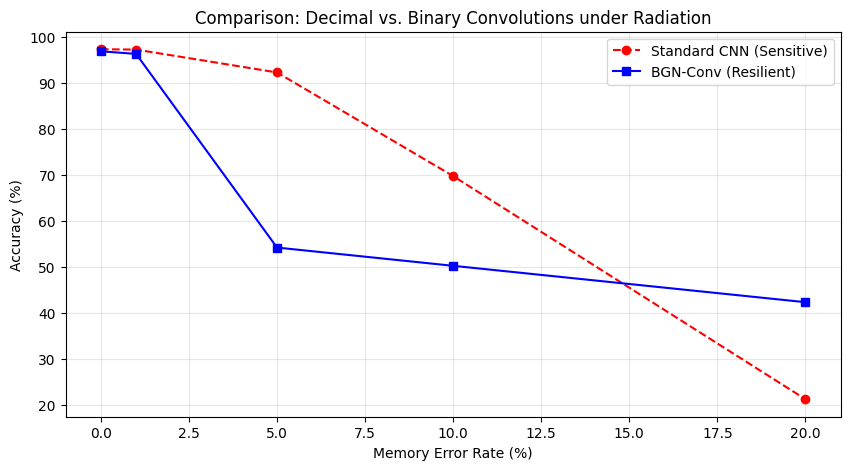

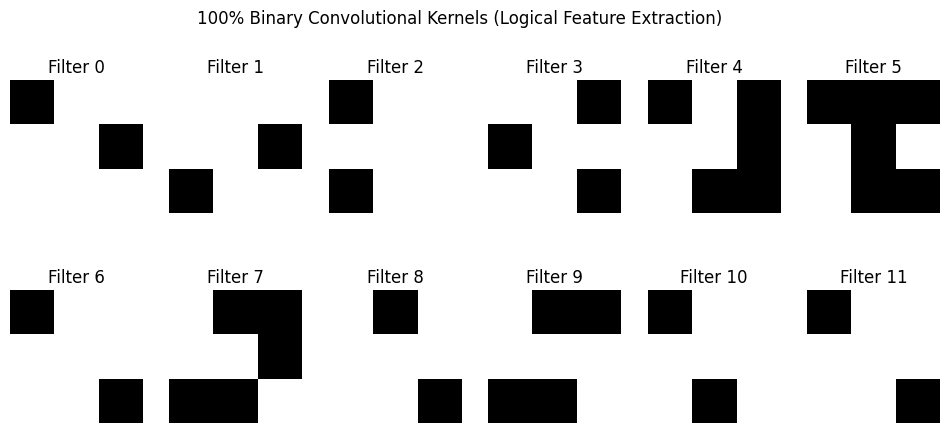

In [4]:
# --- 6. PLOTS ---
rates = [0.0, 0.01, 0.05, 0.10, 0.20]
rates_plot = [0, 1, 5, 10, 20]
print("\nEvaluating Radiation Resilience...")
cnn_res = evaluate_resilience(cnn, test_loader, device, rates)
bgn_res = evaluate_resilience(bgn_conv, test_loader, device, rates)

plt.figure(figsize=(10, 5))
plt.plot(rates_plot, cnn_res, 'ro--', label='Standard CNN (Sensitive)')
plt.plot(rates_plot, bgn_res, 'bs-', label='BGN-Conv (Resilient)')
plt.title('Comparison: Decimal vs. Binary Convolutions under Radiation')
plt.xlabel('Memory Error Rate (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualization of Learned Binary Kernels
kernels = BinaryUnpacker.apply(bgn_conv.conv1.weights).detach().cpu().numpy()
plt.figure(figsize=(12, 5))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(kernels[i, 0], cmap='binary')
    plt.title(f"Filter {i}")
    plt.axis('off')
plt.suptitle("100% Binary Convolutional Kernels (Logical Feature Extraction)")
plt.show()

In [3]:
def estimate_resources_conv():
    # Conv: 16 kernels (3x3) + MLP: 16*13*13 -> 10
    conv_params = (16 * 1 * 3 * 3)
    fc_params = (16 * 13 * 13 * 10)
    total_params = conv_params + fc_params

    size_float_kb = (total_params * 32) / (8 * 1024)
    size_bgn_kb = (total_params * 1) / (8 * 1024)

    print(f"--- Footprint Analysis: BGN-Conv ---")
    print(f"Total Parameters: {total_params}")
    print(f"Float32 Size: {size_float_kb:.2f} KB")
    print(f"BGN (1-bit) Size: {size_bgn_kb:.2f} KB")
    print(f"Memory Reduction: {(1 - size_bgn_kb/size_float_kb)*100:.2f}%")

estimate_resources_conv()

--- Footprint Analysis: BGN-Conv ---
Total Parameters: 27184
Float32 Size: 106.19 KB
BGN (1-bit) Size: 3.32 KB
Memory Reduction: 96.88%
